In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from matplotlib.ticker import ScalarFormatter
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LogNorm
from dataclasses import dataclass
from datasets.dataset import Observable
from typing import Optional

# custom
import torch
import os
import glob
from collections import defaultdict

TRUTH_COLOR = "#07078A"
NEUTRAL_COLOR = "black"
NN_COLOR_red = "#8A0707"
NN_COLOR_green = "#06793F"
NN_COLOR_purple = "#790679"
NN_COLORS = {
    "MLP": NN_COLOR_red,
    "Transformer": NN_COLOR_green,
    "LGATr": NN_COLOR_purple,
    "LGATr-3M": "#4C044C",
}

plt.rc("font", family="serif", size=16)
plt.rc("font", serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)

@dataclass
class Line:
    y: np.ndarray
    y_err: Optional[np.ndarray] = None
    y_ref: Optional[np.ndarray] = None
    label: Optional[str] = None
    color: Optional[str] = None
    linestyle: Optional[str] = "solid"
    fill: bool = False
    vline: bool = False

# Physics utils

In [3]:
minkowski = torch.diag(torch.tensor([1., -1., -1., -1.], dtype=torch.float16))
def covariant2(p1: torch.Tensor, p2: torch.Tensor) -> torch.Tensor:
    """
    Returns the covariant product of two 4-vectors
    """
    # make sure ps and minkowski are the same dtype
    m = minkowski.to(p1.dtype)
    assert p1.dtype == p2.dtype, f"p1 and p2 have different dtypes {p1.dtype} {p2.dtype}"
    return torch.einsum("...i,ij,...j->...", p1, m, p2)

def delta_r(
    p: torch.Tensor, eta1: torch.Tensor, eta2: torch.Tensor, phi1: torch.Tensor, phi2: torch.Tensor
) -> torch.Tensor:
    deta = delta_eta(p, eta1, eta2)
    dphi = delta_phi(p, phi1, phi2)
    return torch.sqrt(deta**2 + dphi**2)


def delta_eta(
    p: torch.Tensor, eta1: torch.Tensor, eta2: torch.Tensor, abs: bool = True
) -> torch.Tensor:
    deta = eta1 - eta2
    return torch.abs(deta) if abs else deta


def delta_phi(
    p: torch.Tensor, phi1: torch.Tensor, phi2: torch.Tensor, abs: bool = True
) -> torch.Tensor:
    dphi = phi1 - phi2
    dphi = (dphi + torch.pi) % (2 * torch.pi) - torch.pi
    return torch.abs(dphi) if abs else dphi

def LorentzProduct(p1, p2, base="EPxPyPz"):
    if base == "PtPhiEtaM":
        p1 = PtPhiEtaM_to_EPxPyPz(p1)
        p2 = PtPhiEtaM_to_EPxPyPz(p2)
    elif base == "EPxPyPz":
        pass
    else:
        raise ValueError(f"Base {base} not recognised")
    return p1[..., 0] * p2[..., 0] - torch.sum(p1[..., 1:] * p2[..., 1:], axis=-1)

def invariant_mass(list_of_p, base="EPxPyPz"):
    """
    list of p is a list of tensors of shape (N, 4) or (N, 3)
    """
    if base == "PtPhiEtaM":
        raise NotImplementedError("PtPhiEtaM not implemented")
    elif base == "EPxPyPz":
        # sum all particles
        stacked = torch.stack(list_of_p, axis=1)   # shape (batch, n_particles, 4)
        summed = stacked.sum(axis=1)          # shape (batch, 4)
        return torch.sqrt(
            summed[..., 0] ** 2 - torch.sum(summed[..., 1:] ** 2, axis=-1)
        )
    
    else:
        raise ValueError(f"Base {base} not recognised")

def mandelstam(p1, p2, p3=None, p4=None, p5=None, p6=None, p7=None, base="EPxPyPz"):
    """
    Mandelstam variable s = (p1 + p2)^2
    """
    if base == "PtPhiEtaM":
        raise NotImplementedError("PtPhiEtaM not implemented")
    elif base == "EPxPyPz":
        # sum all particles
        sqrts = p1+p2
        if p3 is not None:
            sqrts += p3
        if p4 is not None:
            sqrts += p4
        if p5 is not None:
            sqrts += p5
        if p6 is not None:
            sqrts += p6
        if p7 is not None:
            sqrts += p7
        sqrtt = p1-p2
        s = covariant2(sqrts, sqrts)
        t = covariant2(sqrtt, sqrtt)
        return s, t
    
    else:
        raise ValueError(f"Base {base} not recognised")

def PtPhiEtaM_to_EPxPyPz(PtPhiEtaM, cutoff=10):
    if PtPhiEtaM.shape[-1] == 4:
        pt, phi, eta, mass = PtPhiEtaM[:, torch.arange(4)].T
    elif PtPhiEtaM.shape[-1] == 3:
        pt, phi, eta = PtPhiEtaM[:, torch.arange(3)].T
        mass = torch.zeros_like(pt)  # mass is neglected
    else:
        raise ValueError(f"PtPhiEtaM has wrong shape {PtPhiEtaM.shape}")

    px = pt * torch.cos(phi)
    py = pt * torch.sin(phi)
    pz = pt * torch.sinh(torch.clip(eta, -cutoff, cutoff))
    E = torch.sqrt(mass**2 + px**2 + py**2 + pz**2)

    EPxPyPz = torch.stack((E, px, py, pz), axis=-1)
    assert torch.isfinite(
        EPxPyPz
    ).all(), f"{torch.isnan(EPxPyPz).sum(axis=0)} {torch.isinf(EPxPyPz).sum(axis=0)}"
    return EPxPyPz


def EPxPyPz_to_PtPhiEtaM(EPxPyPz):
    pt = get_pt(EPxPyPz)
    phi = get_phi(EPxPyPz)
    eta = get_eta(EPxPyPz)
    mass = get_mass(EPxPyPz)

    PtPhiEtaM = torch.stack((pt, phi, eta, mass), axis=-1)
    assert torch.isfinite(
        PtPhiEtaM
    ).all(), (
        f"{torch.isnan(PtPhiEtaM).sum(axis=0)} {torch.isinf(PtPhiEtaM).sum(axis=0)}"
    )
    return PtPhiEtaM

def get_pt(particle):
    return torch.sqrt(particle[..., 1] ** 2 + particle[..., 2] ** 2)


def get_phi(particle):
    return torch.arctan2(particle[..., 2], particle[..., 1])


def get_eta(particle, eps=1e-10):
    # eta = torch.arctanh(particle[...,3] / p_abs) # numerically unstable
    p_abs = torch.sqrt(torch.sum(particle[..., 1:] ** 2, axis=-1))
    eta = 0.5 * (
        torch.log(torch.clip(torch.abs(p_abs + particle[..., 3]), eps, None))
        - torch.log(torch.clip(torch.abs(p_abs - particle[..., 3]), eps, None))
    )
    return eta


def get_mass(particle, eps=1e-6):
    return torch.sqrt(
        torch.clip(
            particle[..., 0] ** 2 - torch.sum(particle[..., 1:] ** 2, axis=-1),
            eps,
            None,
        )
    )

# Observables utils

In [4]:
def get_hardcoded_bins(n_bins, lower, upper):
    return torch.linspace(lower, upper, n_bins + 1)

def return_obs(p: torch.Tensor, obs: torch.Tensor) -> torch.Tensor:
    return obs

def init_observables(events: torch.Tensor, add_lorentz_products: Optional[bool] = False, add_mandelstam: Optional[bool] = False, add_deltas: Optional[bool] = False) -> list:
    n_particles = (events.shape[-1] - 3) // 4
    observables = []
    n_bins = 50
    for i in range(n_particles):
        observables.append(
            Observable(
                compute=lambda i=i: return_obs(events[..., :], events[..., 4 * i]),
                tex_label=f"E_{{g_{i+1}}}",
                unit="GeV",
                bins=lambda obs: get_hardcoded_bins(
                    n_bins=n_bins + 1, lower=0, upper=1000
                ),
                yscale="linear",
            )
        )
        observables.append(
            Observable(
                compute=lambda i=i: return_obs(events[..., :], events[..., 4 * i + 1]),
                tex_label=f"p_{{x, g_{i+1}}}",
                unit="GeV",
                bins=lambda obs: get_hardcoded_bins(
                    n_bins=n_bins + 1, lower=-500, upper=500
                ),
                yscale="linear",
            )
        )
        observables.append(
            Observable(
                compute=lambda i=i: return_obs(events[..., :], events[..., 4 * i + 2]),
                tex_label=f"p_{{y, g_{i+1}}}",
                unit="GeV",
                bins=lambda obs: get_hardcoded_bins(
                    n_bins=n_bins + 1, lower=-500, upper=500
                ),
                yscale="linear",
            )
        )
        observables.append(
            Observable(
                compute=lambda i=i: return_obs(events[..., :], events[..., 4 * i + 3]),
                tex_label=f"p_{{z, g_{i+1}}}",
                unit="GeV",
                bins=lambda obs: get_hardcoded_bins(
                    n_bins=n_bins + 1, lower=-500, upper=500
                ),
                yscale="linear",
            )
        )
    if add_lorentz_products:
        products = []
        for i in range(n_particles):
            for j in range(i + 1, n_particles):
                products.append(
                    LorentzProduct(
                        events[:, i * 4 : i * 4 + 4], events[:, j * 4 : j * 4 + 4]
                    )
                )
        products = torch.stack(products, axis=-1)
        lorentz_products_events = torch.cat(
            [
                products,
                events[:, -1].unsqueeze(-1),
            ],
            axis=1,
        )
        for i in range(n_particles):
            for j in range(i + 1, n_particles):
                idx = i * n_particles - (i * (i + 1)) // 2 + (j - i - 1)
                observables.append(
                    Observable(
                        compute=lambda idx=idx: return_obs(
                            lorentz_products_events[..., :], lorentz_products_events[..., idx]
                        ),
                        tex_label=f"p_{{g_{i+1}}}\\cdot p_{{g_{j+1}}}",
                        unit=r"\text{GeV}^{2}",
                        bins=(lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=1e4, upper=1e5
                        )) if i == 0 and j == 1 or j == 0 and i == 1 else (lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=0, upper=2e4
                        )),
                        yscale="linear",
                    )
                )
        observables.append(
            Observable(
                compute=lambda: return_obs(
                    lorentz_products_events[..., :], invariant_mass([events[..., 4 * i : 4 * i + 4] for i in range(2, n_particles)])
                ),
                tex_label="m_{\sum_{i=3}^{n}}",
                unit=r"\text{GeV}",
                bins=lambda obs: get_hardcoded_bins(
                    n_bins=n_bins + 1, lower=0, upper=2e3
                ),
                yscale="linear",
            )
        )
        if add_mandelstam:
            observables.append(
                Observable(
                    compute=lambda : return_obs(
                        events[...,:], mandelstam(events[..., 0:4], events[..., 4:8]))[0],
                    tex_label="s_{g_1, g_2}",
                    unit=r"\text{GeV}^{2}",
                    bins=lambda obs: get_hardcoded_bins(
                        n_bins=n_bins + 1, lower=0, upper=5e5
                    ),
                    yscale="linear",
                )
            )
            if n_particles == 6:
                observables.append(
                    Observable(
                        compute=lambda : return_obs(
                            events[...,:], mandelstam(events[..., 8:12], events[..., 12:16], events[..., 16:20], events[..., 20:24]))[0],
                        tex_label="s_{g_3, g_4, g_5, g_6}",
                        unit=r"\text{GeV}^{2}",
                        bins=lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=0, upper=5e5
                        ),
                        yscale="linear",
                    )
                )
            elif n_particles == 7:
                observables.append(
                    Observable(
                        compute=lambda : return_obs(
                            events[...,:], mandelstam(events[..., 8:12], events[..., 12:16], events[..., 16:20], events[..., 20:24]))[0],
                        tex_label="s_{g_3, g_4, g_5, g_6, g_7}",
                        unit=r"\text{GeV}^{2}",
                        bins=lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=0, upper=5e5
                        ),
                        yscale="linear",
                    )
                )
            elif n_particles == 8:
                observables.append(
                    Observable(
                        compute=lambda : return_obs(
                            events[...,:], mandelstam(events[..., 8:12], events[..., 12:16], events[..., 16:20], events[..., 20:24], events[..., 24:28]))[0],
                        tex_label="s_{g_3, g_4, g_5, g_6, g_7, g_8}",
                        unit=r"\text{GeV}^{2}",
                        bins=lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=0, upper=5e5
                        ),
                        yscale="linear",
                    )
                )
            elif n_particles == 9:
                observables.append(
                    Observable(
                        compute=lambda : return_obs(
                            events[...,:], mandelstam(events[..., 8:12], events[..., 12:16], events[..., 16:20], events[..., 20:24], events[..., 24:28], events[..., 28:32]))[0],
                        tex_label="s_{g_3, g_4, g_5, g_6, g_7, g_8, g_9}",
                        unit=r"\text{GeV}^{2}",
                        bins=lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=0, upper=5e5
                        ),
                        yscale="linear",
                    )
                )
            else:
                warnings.warn(
                    f"Cannot compute Mandelstam variables for {n_particles} particles"
                )
        if add_deltas:
            for i in range(n_particles):
                for j in range(i + 1, n_particles):
                    observables.append(
                        Observable(
                            compute=lambda i=i, j=j: return_obs(
                                events[..., :], delta_phi(events[...,:], EPxPyPz_to_PtPhiEtaM(events[..., 4 * i : 4 * i + 4])[..., 1], EPxPyPz_to_PtPhiEtaM(events[..., 4 * j : 4 * j + 4])[..., 1])
                            ),
                            tex_label=f"\Delta \phi (g_{i+1}, g_{j+1})",
                            unit=r"\text{rad}",
                            bins=lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=-0.5, upper=3.5
                            ),
                            yscale="linear",
                        )
                    )
                    observables.append(
                        Observable(
                            compute=lambda i=i, j=j: return_obs(
                                events[..., :], delta_eta(events[...,:], EPxPyPz_to_PtPhiEtaM(events[..., 4 * i : 4 * i + 4])[..., 2], EPxPyPz_to_PtPhiEtaM(events[..., 4 * j : 4 * j + 4])[..., 2])
                            ),
                            tex_label=f"\Delta \eta(g_{i+1}, g_{j+1})",
                            bins=(lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=25, upper=35
                            )) if i == 0 and j == 1 or j == 0 and i == 1 else (lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=10, upper=20
                            )) if i == 0 and j != 1 or j == 0 and i !=1 or i == 1 and j != 0 or j == 1 and i != 0 else (lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=0, upper=8
                            )),
                            yscale="linear",
                        )
                    )
                    observables.append(
                        Observable(
                            compute=lambda i=i, j=j: return_obs(
                                events[..., :], delta_r(events[...,:], EPxPyPz_to_PtPhiEtaM(events[..., 4 * i : 4 * i + 4])[..., 2], EPxPyPz_to_PtPhiEtaM(events[..., 4 * j : 4 * j + 4])[..., 2], EPxPyPz_to_PtPhiEtaM(events[..., 4 * i : 4 * i + 4])[..., 1], EPxPyPz_to_PtPhiEtaM(events[..., 4 * j : 4 * j + 4])[..., 1])
                            ),
                            tex_label=f"\Delta R(g_{i+1}, g_{j+1})",
                            bins=(lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=25, upper=35
                            )) if i == 0 and j == 1 or j == 0 and i == 1 else (lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=10, upper=20
                            )) if i == 0 and j != 1 or j == 0 and i !=1 or i == 1 and j != 0 or j == 1 and i != 0 else (lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=0, upper=8
                            )),
                            yscale="linear",
                        )
                    )

            
    return observables

# Plots utils

In [5]:
def plot_weights(events, predicted_factors_raw, process_name, file: str, model_name: str = None, split="tst", pickle_file: Optional[str] = None):
    """
    Makes plots of the weights learned for Pythia vs Herwig.
    Args:
        file: Output file name
    """
    with PdfPages(file) as pp:
        reweight_factors_truth = (
            events[split][:, -1:]
            .squeeze()
        )
        if "MLP" in predicted_factors_raw or "Transformer" in predicted_factors_raw:
            multiple_models = True
            
        if multiple_models:
            reweight_factors_pred = defaultdict(lambda: defaultdict(list))
            for model in predicted_factors_raw:
                reweight_factors_pred[model] = (
                    predicted_factors_raw[model][split]
                )
        else:
            assert model_name is not None, "Model name must be provided for single model"
            reweight_factors_pred = (
                predicted_factors_raw[split]
            )
        xlim_bins = [0.1, 2.] if "7g" in process_name else [0.2, 1.8] if "6g" in process_name else [0.4, 1.6] if "5g" in process_name else [0.6, 1.4] if "4g" in process_name else [0.4, 1.5]
        bins = np.linspace(*xlim_bins, 64)
        y_truth, y_truth_err = compute_hist_data(
            bins, reweight_factors_truth, bayesian=False
        )
        if multiple_models:
            y_pred, y_pred_err = defaultdict(lambda: defaultdict(list)), defaultdict(lambda: defaultdict(list))
            for model in predicted_factors_raw:
                y_pred[model], y_pred_err[model] = compute_hist_data(
                    bins, reweight_factors_pred[model], bayesian=False
                )
        else:
            y_pred, y_pred_err = compute_hist_data(
                bins, reweight_factors_pred, bayesian=False
            )
        lines = [
            Line(
                y=y_truth,
                y_err=y_truth_err,
                label="Truth",
                color=TRUTH_COLOR,
            ),
        ]
        if multiple_models:
            for model in predicted_factors_raw:
                lines.append(
                    Line(
                        y=y_pred[model],
                        y_err=y_pred_err[model],
                        y_ref=y_truth,
                        label=f"{model}",
                        color=NN_COLORS[model],
                        linestyle="solid" if model != "LGATr-3M" else "dashed",
                    )
                )
        else:
            lines.append(
                Line(
                    y=y_pred,
                    y_err=y_pred_err,
                    y_ref=y_truth,
                    label=f"{model_name}",
                    color=NN_COLORS[model_name],
                )
            )
        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=True,
            title=process_name if process_name is not None else None,
            model_name=model,
            multiple_models=multiple_models,
        )
        
        xlim_bins = [0.5, 1.5]
        bins = np.linspace(*xlim_bins, 64)
        lines = []
        if multiple_models:
            ratios = defaultdict(lambda: defaultdict(list))
            y_diff, y_diff_err = defaultdict(lambda: defaultdict(list)), defaultdict(lambda: defaultdict(list))
            for model in predicted_factors_raw:
                ratios[model] = reweight_factors_truth / reweight_factors_pred[model]
                y_diff[model], y_diff_err[model] = compute_hist_data(bins, ratios[model], bayesian=False)
                lines.append(
                    Line(
                        y=y_diff[model],
                        y_err=y_diff_err[model],
                        label=f"$\\frac{{\\text{{Truth}}}}{{\\text{{{model}}}}}$",
                        color=NN_COLORS[model],
                        linestyle="solid" if model != "LGATr-3M" else "dashed",
                    )
                )
        else:
            ratios = reweight_factors_truth / reweight_factors_pred
            y_diff, y_diff_err = compute_hist_data(bins, ratios, bayesian=False)
            lines.append(
                Line(
                    y=y_diff,
                    y_err=y_diff_err,
                    label=f"$\\frac{{\\text{{Truth}}}}{{\\text{{{model_name}}}}}$",
                    color=NN_COLORS[model_name],
                )
            )
        
        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$\text{Ratio}$",
            model_name=model_name,
            title=process_name if process_name is not None else None,
            multiple_models=multiple_models,
        )

def plot_weights_ppd(
        events_ppd, predicted_factors_ppd, model_name, file: str, split="tst", pickle_file: Optional[str] = None
):
    """
    Makes plots of the weights learned for Pythia vs Herwig.
    Args:
        file: Output file name
    """
    with PdfPages(file) as pp:
        reweight_factors_truth = (
            events_ppd[split][:, -1:]
        )
        reweight_factors_pred = (
            predicted_factors_ppd[split]
        )

        xlim_bins = [0, 3]
        bins = np.linspace(*xlim_bins, 64)
        y_truth, y_truth_err = compute_hist_data(
            bins, reweight_factors_truth, bayesian=False
        )
        y_pred, y_pred_err = compute_hist_data(
            bins, reweight_factors_pred, bayesian=False
        )

        lines = [
            Line(
                y=y_truth,
                y_err=y_truth_err,
                label="Truth",
                color=TRUTH_COLOR,
            ),
            Line(
                y=y_pred,
                y_err=y_pred_err,
                y_ref=y_truth,
                label=f"{model_name}",
                color=NN_COLORS[model_name],
            ),
        ]
        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=True,
            title=process_name if process_name is not None else None,
            model_name=model_name,
        )

        ratios = reweight_factors_truth / reweight_factors_pred
        bins = np.linspace(*xlim_bins, 64)
        y_diff, y_diff_err = compute_hist_data(bins, ratios, bayesian=False)
        lines = [
            Line(
                y=y_diff,
                y_err=y_diff_err,
                label=f"$\\frac{{\\text{{Truth}}}}{{\\text{{{model_name}}}}}$",
                color=NN_COLORS[model_name],
            ),
        ]
        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$\text{Ratio}$",
            model_name=model_name,
            title=process_name if process_name is not None else None,
        )

def plot_ratio_correlation(
        events, predicted_factors_raw, process_name, file: str, model_name: str = None, split="tst", pickle_file: Optional[str] = None
):
    with PdfPages(file) as pp:
        cmap = plt.get_cmap("viridis")
        cmap.set_bad("white")

        ylim_bins = [0.75, 1.6] if "7g" in process_name else [0.75, 1.4] if "6g" in process_name else [0.8, 1.2] if "5g" in process_name else [0.85, 1.05] if "4g" in process_name else [0.4, 1.5]
        xlim_bins = [0.5, 1.5]

        xbins = np.linspace(*xlim_bins, 64)
        ybins = np.linspace(*ylim_bins, 64)
        reweight_factors_truth = (
            events[split][:, -1:]
            .squeeze()
        )
        reweight_factors_pred = (
            predicted_factors_raw[split]
        )
        ratios = reweight_factors_truth / reweight_factors_pred
        pickle_data = []
        h, x, y = np.histogram2d(ratios, reweight_factors_pred, bins=(xbins, ybins))
        # h = np.ma.divide(h, np.sum(h, -1, keepdims=True)).filled(0)
        h[h == 0] = np.nan
        h_norm = h / np.nansum(h)
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.pcolormesh(
            xbins,
            ybins,
            h_norm.T, # need to transpose for pcolormesh
            cmap=cmap,
            norm=LogNorm(vmin=np.nanmin(h_norm), vmax=np.nanmax(h_norm)),
            rasterized=True,
        )
        # plt.colorbar()
        fig.suptitle(f"{model_name}")
        ax.set_xlim(xbins[0], xbins[-1])
        ax.set_ylim(ybins[0], ybins[-1])
        ax.set_xlabel("$r/\hat{r}$")
        ax.set_ylabel("$\hat{r}$")

        fig.savefig(pp, format="pdf", bbox_inches="tight")
        plt.close()
        if pickle_file is not None:
            pickle_data.append({"h": h, "bins": bins})
    if pickle_file is not None:
        with open(pickle_file, "wb") as f:
            pickle.dump(pickle_data, f)

def hist_weights_plot(
    pdf: PdfPages,
    lines: list[Line],
    bins: np.ndarray,
    show_ratios: bool = False,
    title: Optional[str] = None,
    xlabel: str = r"$r(x)$",
    no_scale: bool = False,
    model_name: str = "NN",
    yscale: Optional[str] = None,
    show_metrics: bool = False,
    ylim: tuple[float, float] = None,
    multiple_models: bool = False,
):
    """
    Makes a single histogram plot for the weights
    Args:
        pdf: Multipage PDF object
        lines: List of line objects describing the histograms
        bins: Numpy array with the bin boundaries
        show_ratios: If True, show a panel with ratios
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)

        n_panels = 1 + int(show_ratios) + int(show_metrics)
        fig, axs = plt.subplots(
            n_panels,
            1,
            sharex=True,
            figsize=(6, 4.5),
            gridspec_kw={"height_ratios": (12, 3, 1)[:n_panels], "hspace": 0.00},
        )
        if n_panels == 1:
            axs = [axs]

        for line in lines:
            if line.vline:
                axs[0].axvline(
                    line.y,
                    label=line.label,
                    color=line.color,
                    linestyle=line.linestyle,
                )
                continue
            integral = np.sum((bins[1:] - bins[:-1]) * line.y)
            scale = 1 / integral if integral != 0.0 else 1.0
            if line.y_ref is not None:
                ref_integral = np.sum((bins[1:] - bins[:-1]) * line.y_ref)
                ref_scale = 1 / ref_integral if ref_integral != 0.0 else 1.0
            if no_scale:
                scale = 1.0
                ref_scale = 1.0

            hist_line(
                axs[0],
                bins,
                line.y * scale,
                line.y_err * scale if line.y_err is not None else None,
                label=line.label,
                color=line.color,
                fill=line.fill,
                linestyle=line.linestyle,
            )

            if line.y_ref is not None:
                ratio = (line.y * scale) / (line.y_ref * ref_scale)
                ratio_isnan = np.isnan(ratio)
                if line.y_err is not None:
                    if len(line.y_err.shape) == 2:
                        ratio_err = (line.y_err * scale) / (line.y_ref * ref_scale)
                        ratio_err[:, ratio_isnan] = 0.0
                    else:
                        ratio_err = np.sqrt((line.y_err / line.y) ** 2)
                        ratio_err[ratio_isnan] = 0.0
                else:
                    ratio_err = None
                ratio[ratio_isnan] = 1.0
                hist_line(
                    axs[1], bins, ratio, ratio_err, label=None, color=line.color, fill=line.fill, linestyle=line.linestyle
                )
        if show_ratios:
            if not multiple_models:
                axs[1].set_ylabel(
                    f"$\\frac{{\\text{{{model_name}}}}}{{\\text{{Truth}}}}$"
                )
            else:
                axs[1].set_ylabel(
                    "$\\frac{\\text{NN}}{\\text{Truth}}$"
                )
            axs[1].set_yticks([0.75, 1, 1.25])
            axs[1].set_ylim([0.5, 1.5])
            axs[1].axhline(y=1, c="black", ls="--", lw=0.7)
            axs[1].axhline(y=1.25, c="black", ls="dotted", lw=0.5)
            axs[1].axhline(y=0.75, c="black", ls="dotted", lw=0.5)

        if title is not None:
            corner_text(axs[0], title, "left", "top")
        axs[0].legend(loc="best", frameon=False)
        axs[0].set_ylabel("Normalized")
        axs[0].set_yscale("log" if yscale is None else yscale)
        if ylim is not None:
            axs[0].set_ylim(*ylim)

        axs[-1].set_xlabel(xlabel)
        # axs[-1].set_xscale("log")
        axs[-1].set_xlim(bins[0], bins[-1])
        plt.savefig(pdf, format="pdf", bbox_inches="tight")
        plt.close()


def compute_hist_data(bins: np.ndarray, data: np.ndarray, bayesian=False, weights=None):
    if bayesian:
        hists = np.stack(
            [
                np.histogram(d, bins=bins, density=False, weights=weights)[0]
                for d in data
            ],
            axis=0,
        )
        y = hists[0]
        y_err = np.std(hists, axis=0)
    else:
        y, _ = np.histogram(data, bins=bins, density=False, weights=weights)
        y_err = np.sqrt(y)
    return y, y_err


def hist_plot(
    pdf: PdfPages,
    lines: list[Line],
    bins: np.ndarray,
    observable: Observable,
    show_ratios: bool = True,
    title: Optional[str] = None,
    legend_kwargs: Optional[dict] = None,
    no_scale: bool = False,
    yscale: Optional[str] = None,
    debug=False,
    model_name: str = "NN",
):
    """
    Makes a single histogram plot, used for the observable histograms and clustering
    histograms.
    Args:
        pdf: Multipage PDF object
        lines: List of line objects describing the histograms
        bins: Numpy array with the bin boundaries
        show_ratios: If True, show a panel with ratios
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)

        n_panels = 1 + int(show_ratios)
        fig, axs = plt.subplots(
            n_panels,
            1,
            sharex=True,
            figsize=(6, 4.5),
            gridspec_kw={"height_ratios": (12, 3, 1)[:n_panels], "hspace": 0.00},
        )
        fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=(0.08, 0.1, 0.97, 0.96))
        if n_panels == 1:
            axs = [axs]

        for line in lines:
            if line.vline:
                axs[0].axvline(
                    line.y, label=line.label, color=line.color, linestyle=line.linestyle
                )
                continue
            integral = np.sum((bins[1:] - bins[:-1]) * line.y)
            scale = 1 / integral if integral != 0.0 else 1.0
            if line.y_ref is not None:
                ref_integral = np.sum((bins[1:] - bins[:-1]) * line.y_ref)
                ref_scale = 1 / ref_integral if ref_integral != 0.0 else 1.0
            if no_scale:
                scale = 1.0
                ref_scale = 1.0

            if debug:
                print("plotting", observable.tex_label)
            if debug:
                print("Actual values plotted:", line.y * scale)

            hist_line(
                axs[0],
                bins,
                line.y * scale,
                line.y_err * scale if line.y_err is not None else None,
                label=line.label,
                color=line.color,
                fill=line.fill,
                linestyle=line.linestyle,
            )

            if line.y_ref is not None:
                ratio = (line.y * scale) / (line.y_ref * ref_scale)
                ratio_isnan = np.isnan(ratio)
                if line.y_err is not None:
                    if len(line.y_err.shape) == 2:
                        ratio_err = (line.y_err * scale) / (line.y_ref * ref_scale)
                        ratio_err[:, ratio_isnan] = 0.0
                    else:
                        ratio_err = np.sqrt((line.y_err / line.y) ** 2)
                        ratio_err[ratio_isnan] = 0.0
                else:
                    ratio_err = None
                ratio[ratio_isnan] = 1.0
                hist_line(
                    axs[1],
                    bins,
                    ratio,
                    ratio_err,
                    label=None,
                    color=line.color,
                    linestyle=line.linestyle,
                )


        if title is not None:
            corner_text(axs[0], title, "left", "top")
        axs[0].legend(
            frameon=False, **(legend_kwargs if legend_kwargs is not None else {})
        )
        axs[0].set_ylabel("Normalized") if not no_scale else axs[0].set_ylabel("Events")
        axs[0].set_yscale(observable.yscale if yscale is None else yscale)

        if show_ratios:
            axs[1].set_ylabel(
                f"$\\frac{{\\text{{{model_name}}}}}{{\\text{{Truth}}}}$"
            )
            axs[1].set_yticks([0.75, 1, 1.25])
            axs[1].set_ylim([0.5, 1.5])
            axs[1].axhline(y=1, c="black", ls="--", lw=0.7)
            axs[1].axhline(y=1.25, c="black", ls="dotted", lw=0.5)
            axs[1].axhline(y=0.75, c="black", ls="dotted", lw=0.5)

        unit = "" if observable.unit is None else f"[{observable.unit}]"
        axs[-1].set_xlabel(f"${{{observable.tex_label}}}$ $\ {unit}$")
        axs[-1].set_xscale(observable.xscale)
        axs[-1].set_xlim(bins[0], bins[-1])
        plt.savefig(pdf, format="pdf")
        plt.close()


def hist_line(
    ax: mpl.axes.Axes,
    bins: np.ndarray,
    y: np.ndarray,
    y_err: np.ndarray,
    label: str,
    color: str,
    linestyle: str = "solid",
    fill: bool = False,
):
    """
    Plot a stepped line for a histogram, optionally with error bars.
    Args:
        ax: Matplotlib Axes
        bins: Numpy array with bin boundaries
        y: Y values for the bins
        y_err: Y errors for the bins
        label: Label of the line
        color: Color of the line
        linestyle: line style
        fill: Filled histogram
    """

    dup_last = lambda a: np.append(a, a[-1])

    if fill:
        ax.fill_between(
            bins, dup_last(y), label=label, facecolor=color, step="post", alpha=0.2
        )
    else:
        ax.step(
            bins,
            dup_last(y),
            label=label,
            color=color,
            linewidth=1.0,
            where="post",
            ls=linestyle,
        )
    if y_err is not None:
        if len(y_err.shape) == 2:
            y_low = y_err[0]
            y_high = y_err[1]
        else:
            y_low = y - y_err
            y_high = y + y_err

        ax.step(
            bins,
            dup_last(y_high),
            color=color,
            alpha=0.3,
            linewidth=0.5,
            where="post",
        )
        ax.step(
            bins,
            dup_last(y_low),
            color=color,
            alpha=0.3,
            linewidth=0.5,
            where="post",
        )
        ax.fill_between(
            bins,
            dup_last(y_low),
            dup_last(y_high),
            facecolor=color,
            alpha=0.15,
            step="post",
        )


def corner_text(ax: mpl.axes.Axes, text: str, horizontal_pos: str, vertical_pos: str):
    ax.text(
        x=0.95 if horizontal_pos == "right" else 0.05,
        y=0.95 if vertical_pos == "top" else 0.05,
        s=text,
        horizontalalignment=horizontal_pos,
        verticalalignment=vertical_pos,
        transform=ax.transAxes,
    )
    # Dummy line for automatic legend placement
    plt.plot(
        0.8 if horizontal_pos == "right" else 0.2,
        0.8 if vertical_pos == "top" else 0.2,
        transform=ax.transAxes,
        color="none",
    )

def plot_observables(observables, bins, obs, process_name, file: str, model_name=None, pickle_file: Optional[str] = None, mask=None, no_scale=False,yscale=None, debug=False):
    """
    Makes histograms of truth and generated distributions for all observables.
    Args:
        file: Path to the output PDF file
        pickle_file: Path to the output pickle file (optional)
    """
    pickle_data = []
    with PdfPages(file) as pp:
        for obser, bins, data in zip(
            observables,
            bins,
            obs,
        ): 

            y, y_err = compute_hist_data(bins, data, bayesian=False)
            
            lines = [
                Line(
                    y=y,
                    y_err=y_err,
                    label="Events",
                    color=TRUTH_COLOR,
                ),
            ]
            if mask is not None:
                data_f = data[mask]
                y, y_err = compute_hist_data(bins, data_f, bayesian=False)
                lines.append(
                    Line(
                        y=y,
                        y_err=y_err,
                        label="Factor-filtered",
                        color=TRUTH_COLOR,
                        linestyle="dashed",
                    )
                )
            hist_plot(
                pp,
                lines,
                bins,
                observable=obser,
                show_ratios=False,
                title=process_name,
                model_name=model_name,
                no_scale=no_scale,
                yscale=yscale,
                debug=debug,
            )
            if pickle_file is not None:
                pickle_data.append({"lines": lines, "bins": bins, "obs": obs})
    if pickle_file is not None:
        with open(pickle_file, "wb") as f:
            pickle.dump(pickle_data, f)

# Load data

In [6]:
data_dir = "../../data/gg_ng/large/" if os.path.exists("../../data/gg_ng/large/") else "/remote/gpu02/marino/data/gg_ng/large/"
datasets_names = ["gg_4g", "gg_5g", "gg_6g", "gg_7g"]
# read data and pass to tensors
datasets = {
    datasets_names[0]: np.load(os.path.join(data_dir, "events_6_2_21_21_21_21_21_21_1_2_3_4_5_6.lhe.rwgt.npy")),
    datasets_names[1]: np.load(os.path.join(data_dir, "events_7_2_21_21_21_21_21_21_21_1_2_3_4_5_6_7.lhe.rwgt.npy")),
    datasets_names[2]: np.load(os.path.join(data_dir, "events_8_2_21_21_21_21_21_21_21_21_1_2_3_4_5_6_7_8.lhe.rwgt.npy")),
    datasets_names[3]: np.load(os.path.join(data_dir, "events_9_2_21_21_21_21_21_21_21_21_21_1_2_3_4_5_6_7_8_9.lhe.rwgt.npy")),
}

# Understanding the dataset

Text(0, 0.5, 'Normalized')

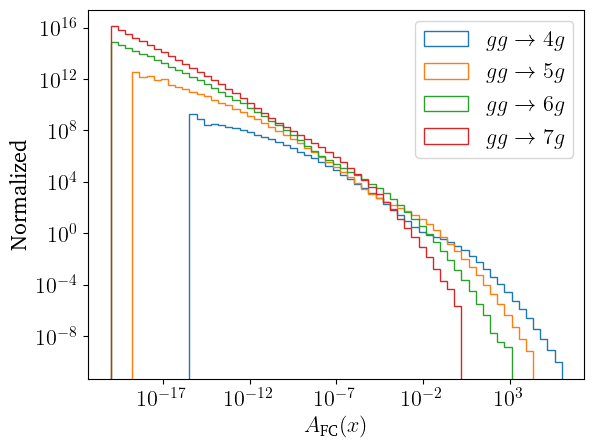

In [14]:
# bins = np.logspace(-30, 10, 64)
bins=np.logspace(-20, 6, 64)
for process_name in datasets:
    plt.hist(datasets[process_name][:, -1], bins=bins, histtype="step", label=f"${process_name[:2]}\\to {process_name[-2:]}$", density=True)
    plt.xscale("log")
    plt.yscale("log")
plt.legend()
plt.xlabel(r"$A_{\text{FC}}(x)$")
plt.ylabel(r"Normalized")

/tmp/ipykernel_1818196/867094478.py:11: RuntimeWarning: invalid value encountered in divide
  ratios.append(h_ / hcopy)
/tmp/ipykernel_1818196/867094478.py:11: RuntimeWarning: divide by zero encountered in divide
  ratios.append(h_ / hcopy)


Text(0, 0.5, 'Normalized')

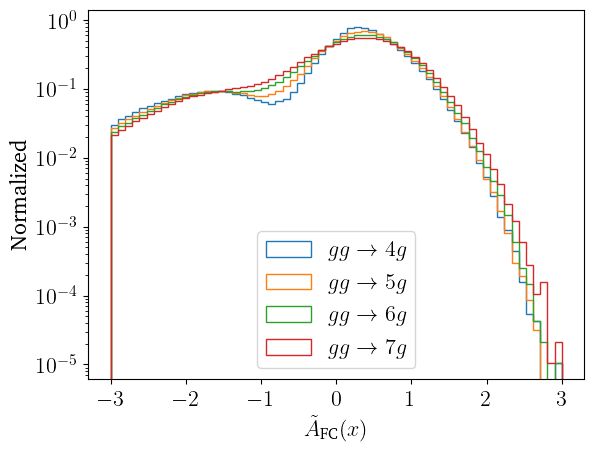

In [15]:
# bins = np.logspace(-30, 10, 64)

bins=np.linspace(-3, 3, 64)
ratios = []
for i, process_name in enumerate(datasets):
    A_ppd = (np.log(datasets[process_name][:, -1]) - np.mean(np.log(datasets[process_name][:, -1]))) / np.std(np.log(datasets[process_name][:, -1]))
    h_, bins_, _ = plt.hist(A_ppd, bins=bins, histtype="step", label=f"${process_name[:2]}\\to {process_name[-2:]}$", density=True)
    if i == 0:
        hcopy = h_.copy()
    else:
        ratios.append(h_ / hcopy)
        hcopy = h_.copy()
    # plt.xscale("log")
    plt.yscale("log")
plt.legend()
plt.xlabel(r"$\tilde{A}_{\text{FC}}(x)$")
plt.ylabel(r"Normalized")

(0.8, 2.0)

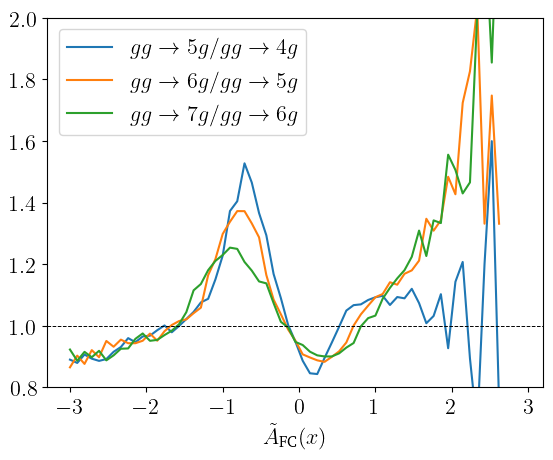

In [16]:
for r, (i , k) in zip(ratios, enumerate(datasets_names)):
    plt.plot(bins[:-1], r, label=f"${datasets_names[i+1][:2]}\\to {datasets_names[i+1][-2:]} / {datasets_names[i][:2]}\\to {datasets_names[i][-2:]}$")
plt.axhline(y=1, c="black", ls="--", lw=0.7)
plt.legend()
plt.xlabel(r"$\tilde{A}_{\text{FC}}(x)$")
plt.ylim(0.8, 2)

In [ ]:
for (process_name, dataset) in zip(datasets.keys(), datasets.values()):

    observables_initd = init_observables(torch.from_numpy(dataset), add_lorentz_products=True, add_mandelstam=True, add_deltas=True)
    observables = []
    obs_list = []
    bins_list = []
    for obs in observables_initd:
        o = obs.compute()
        bin = obs.bins(o)
        observables.append(obs)
        obs_list.append(o.cpu().numpy())
        bins_list.append(bin.cpu().numpy())
    
    plot_observables(
        observables,
        bins_list,
        obs_list,
        process_name=f"${process_name[:2]}\\to {process_name[-2:]}$",
        file=f"figs/dataset/{process_name}-filtered_secondarypeak.pdf",
        model_name="NN",
        mask=(np.log(dataset[:,-1]) - np.mean(np.log(dataset[:,-1]))) / np.std(np.log(dataset[:,-1])) < -0.9,
        no_scale=True,
    )

## Shapley values

In [8]:
dataset = datasets["gg_4g"]
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Assume p is your tensor of shape (N, D)
X = dataset[:, :-3]  # Features
y = dataset[:, -1]   # Target

# Fit a model
model = RandomForestRegressor(n_estimators=2).fit(X, y)

In [9]:
# Create SHAP explainer
explainer = shap.Explainer(model, X)

# Compute SHAP values
shap_values = explainer(X)

# Beeswarm plot
shap.summary_plot(shap_values, X)


: 

In [19]:
np.arange(2, 7 * 4, 4)

array([ 2,  6, 10, 14, 18, 22, 26])

# Benchmarks

## Weights and ratio correlations

In [156]:
# Load samples from 
datasets = ["gg_4g", "gg_5g", "gg_6g", "gg_7g"]
events = defaultdict(lambda: defaultdict(dict))
samples = defaultdict(lambda: defaultdict(dict))
models = ["Transformer", "MLP", "LGATr", "LGATr-3M"]
for model in models:
    for dataset in datasets:
        for split in ["tst"]:
            path = glob.glob(f"files/benchmarks/Transformer/*-benchmark-{dataset}/samples/events_{split}.pt")[0]
            events[dataset][split] = torch.load(path, map_location="cpu").squeeze().numpy()
            if model == "Transformer":
                samples[dataset][model][split] = torch.load(glob.glob(f"files/benchmarks/{model}/*-benchmark-{dataset}*one_hot/samples/predicted_factors_{split}.pt")[0], map_location="cpu").squeeze().numpy()
            else:
                samples[dataset][model][split] = torch.load(glob.glob(f"files/benchmarks/{model}/*-benchmark-{dataset}*/samples/predicted_factors_{split}.pt")[0], map_location="cpu").squeeze().numpy()

In [105]:
for process_name in datasets:
    plot_weights(
        events[process_name],
        samples[process_name],
        process_name=f"${process_name[:2]}\\to {process_name[-2:]}$",
        file=f"figs/benchmarks/{process_name}-weights.pdf",
        split="tst",
    )
    for model in models:
        plot_ratio_correlation(
            events[process_name],
            samples[process_name][model],
            process_name=f"${process_name[:2]}\\to {process_name[-2:]}$",
            file=f"figs/benchmarks/{process_name}-{model}-ratio_corr.pdf",
            model_name=model,
            split="tst",
        )

## Validation losses

In [106]:
def load_model_paths(base_dir, models, datasets):
    model_dict = defaultdict(dict)
    pattern = os.path.join(base_dir, "**", "model", "best.pth")
    model_paths = glob.glob(pattern, recursive=True)
    print(model_paths)

    for path in model_paths:
        # Break path into parts
        parts = path.split(os.sep)

        # Search for the "benchmarks" index to locate model and run folder
        try:
            bench_idx = parts.index("benchmarks")
            model = parts[bench_idx + 1]
            run_folder = parts[bench_idx + 2]
        except (ValueError, IndexError):
            continue

        # Extract dataset from run folder name like "0415_153319-benchmark-gg_4g"
        if "-benchmark-" in run_folder:
            dataset = run_folder.split("-benchmark-")[-1]
        else:
            continue

        if model in models and dataset in datasets:
            model_dict[dataset][model] = path

    return model_dict

# Example usage
base_folder = "/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks"
models = ["Transformer", "MLP", "LGATr", "LGATr-3M"]
datasets = ["gg_4g", "gg_5g", "gg_6g", "gg_7g"]

model_dict = dict(sorted(load_model_paths(base_folder, models, datasets).items()))

best_val_models = defaultdict(dict)
best_val = defaultdict(dict)

for dataset in datasets:
    for model in models:
        path = model_dict.get(dataset, {}).get(model, None)
        if path:
            print(f"{dataset} - {model}")
            best_val_models[dataset][model] = torch.load(path, map_location=torch.device('cpu'))
            loss_vals = best_val_models[dataset][model]["losses"]["val"]
            assert loss_vals[-1] == min(loss_vals)
            assert np.argmin(loss_vals)+1 == len(loss_vals)
            best_val[dataset][model] = np.min(loss_vals)
            print("Best_val_loss:", best_val[dataset][model])


['/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0416_012532-benchmark-gg_6g-one_hot/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0415_182151-benchmark-gg_4g-one_hot/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0415_153238-benchmark-gg_4g/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0415_153307-benchmark-gg_7g/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0416_044055-benchmark-gg_7g-one_hot/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0415_215149-benchmark-gg_5g-one_hot/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/

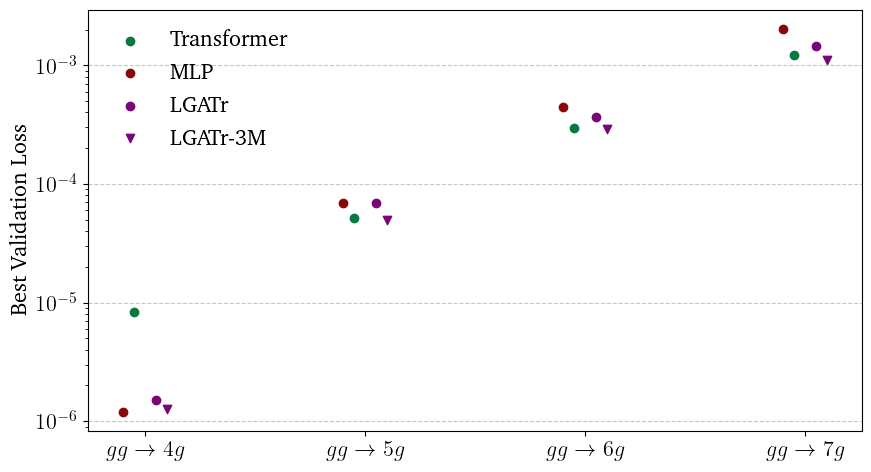

In [107]:
# Create x positions for the datasets
x = np.arange(len(datasets))
fig, ax = plt.subplots(figsize=(9, 5))

offsets = {
    "MLP": -0.1,
    "Transformer": -0.05,
    "LGATr": 0.05,
    "LGATr-3M": 0.1,
}
for model in models:
    # For each dataset, get the best validation loss for the current model.
    # If a model is missing for a dataset, use np.nan.
    y = [best_val[ds].get(model, np.nan) for ds in datasets]
    if model =="LGATr-3M":
        # Plot the data with a different color
        ax.scatter(x + offsets[model], y, marker="v", label=model, color = NN_COLORS["LGATr"])
    else:
        ax.scatter(x + offsets[model], y, marker='o', label=model, color = NN_COLORS[model])

# Set x-axis tick labels to dataset names
names = [f"${d[:2]}\\to {d[-2:]}$" for d in datasets]
ax.set_xticks(x, names)
ax.set_ylabel("Best Validation Loss")
ax.set_yscale("log")

ax.grid(axis='y', which="major", linestyle='--', alpha=0.7)
ax.legend(frameon=False, loc="best")
fig.tight_layout()
fig.savefig("figs/benchmarks/best_val_loss.pdf", bbox_inches="tight")

In [60]:
def load_model_paths(base_dir):
    model_dict = {}
    
    # Recursively search for best.pth files
    pattern = os.path.join(base_dir, "**/model/best.pth")
    model_paths = glob.glob(pattern, recursive=True)
    
    for path in model_paths:
        # Extract folder name containing the model info
        model_dir_name = os.path.basename(os.path.dirname(os.path.dirname(path)))
        
        # Remove timestamp and '-naive-hs-' if present
        cleaned_name = model_dir_name
        if '-' in cleaned_name:
            cleaned_name = '-'.join(cleaned_name.split('-')[1:])  # Remove the timestamp part
        cleaned_name = cleaned_name.replace("naive-hs-", "")      # Remove this literal string
        
        model_dict[cleaned_name] = path
    
    return model_dict

# Example usage:
base_folder = "/Users/jamarino/Downloads/hyperparam-search"
model_dict = dict(sorted(load_model_paths(base_folder).items()))

best_val_models = {}
best_val = {}
for k, v in model_dict.items():
    print(f"{k}: {v}")
    best_val_models[k] = torch.load(v, map_location=torch.device('cpu'))
    print("Best_val_loss:", np.min(best_val_models[k]["losses"]["val"]), np.argmin(best_val_models[k]["losses"]["val"]))
    best_val[k] = np.min(best_val_models[k]["losses"]["val"])


100k-perm_inv_False-lr_1e-3-sched_CosAnneal: /Users/jamarino/Downloads/hyperparam-search/20250410_191538-100k-naive-hs-perm_inv_False-lr_1e-3-sched_CosAnneal/model/best.pth
Best_val_loss: 6.378479884006083e-05 98
100k-perm_inv_False-lr_1e-3-sched_null: /Users/jamarino/Downloads/hyperparam-search/20250410_150005-100k-naive-hs-perm_inv_False-lr_1e-3-sched_null/model/best.pth
Best_val_loss: 6.929899973329157e-05 86
100k-perm_inv_False-lr_1e-4-sched_CosAnneal: /Users/jamarino/Downloads/hyperparam-search/20250410_192628-100k-naive-hs-perm_inv_False-lr_1e-4-sched_CosAnneal/model/best.pth
Best_val_loss: 0.0002532142389100045 98
100k-perm_inv_False-lr_1e-4-sched_null: /Users/jamarino/Downloads/hyperparam-search/20250410_150221-100k-naive-hs-perm_inv_False-lr_1e-4-sched_null/model/best.pth
Best_val_loss: 0.00014586266479454935 98
100k-perm_inv_False-lr_1e-5-sched_CosAnneal: /Users/jamarino/Downloads/hyperparam-search/20250410_193121-100k-naive-hs-perm_inv_False-lr_1e-5-sched_CosAnneal/model/bes

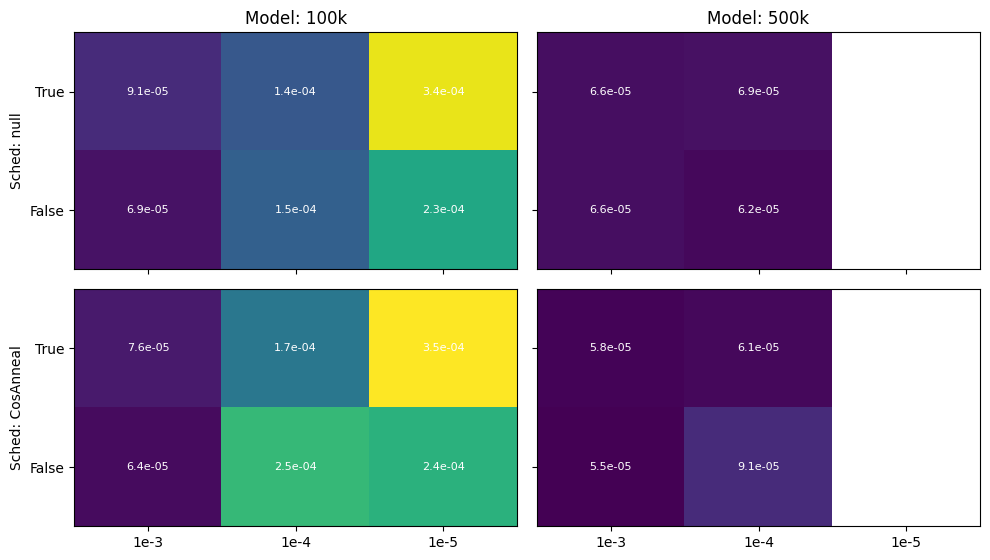

In [61]:
import numpy as np

# Define grid axes
model_sizes = ['100k', '500k']
perm_inv_flags = ['True', 'False']
lrs = ['1e-3', '1e-4', '1e-5']
scheds = ['null', 'CosAnneal']

# Initialize 4D grid with NaNs
val_grid = np.full((len(model_sizes), len(perm_inv_flags), len(lrs), len(scheds)), np.nan)

# Fill the grid
for key, val in best_val.items():
    for i, ms in enumerate(model_sizes):
        if ms in key:
            for j, pi in enumerate(perm_inv_flags):
                if f'perm_inv_{pi}' in key:
                    for k, lr in enumerate(lrs):
                        if f'lr_{lr}' in key:
                            for l, sched in enumerate(scheds):
                                if f'sched_{sched}' in key:
                                    val_grid[i, j, k, l] = val


# Plotting grid: rows = scheds, cols = model_sizes
fig, axs = plt.subplots(
    nrows=len(scheds),
    ncols=len(model_sizes),
    figsize=(10, 6),
    sharex=True,
    sharey=True
)

for i, sched in enumerate(scheds):         # rows
    for j, ms in enumerate(model_sizes):   # cols
        ax = axs[i, j]
        data = val_grid[j, :, :, i]  # Shape: [perm_inv, lr]
        im = ax.imshow(data, cmap='viridis', aspect='auto', vmin=np.nanmin(val_grid), vmax=np.nanmax(val_grid))

        # Set ticks
        ax.set_xticks(np.arange(len(lrs)))
        ax.set_xticklabels(lrs)
        ax.set_yticks(np.arange(len(perm_inv_flags)))
        ax.set_yticklabels(perm_inv_flags)

        # Titles and labels
        if i == 0:
            ax.set_title(f"Model: {ms}")
        if j == 0:
            ax.set_ylabel(f"Sched: {sched}")

        # Annotate values
        for pi in range(len(perm_inv_flags)):
            for lr in range(len(lrs)):
                val = data[pi, lr]
                if not np.isnan(val):
                    ax.text(lr, pi, f"{val:.1e}", ha="center", va="center", color="white", fontsize=8)

# fig.suptitle("Validation Loss Heatmaps\nRows: perm_inv | Columns: lr", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
# cbar.set_label("Validation Loss")
fig.savefig("val_loss_heatmap1.pdf", dpi=300)
plt.show()

In [62]:
def load_model_paths(base_dir):
    model_dict = {}
    
    # Recursively search for best.pth files
    pattern = os.path.join(base_dir, "**/model/best.pth")
    model_paths = glob.glob(pattern, recursive=True)
    
    for path in model_paths:
        # Extract folder name containing the model info
        model_dir_name = os.path.basename(os.path.dirname(os.path.dirname(path)))
        
        # Remove timestamp and '-naive-hs-' if present
        cleaned_name = model_dir_name
        if '-' in cleaned_name:
            cleaned_name = '-'.join(cleaned_name.split('-')[1:])  # Remove the timestamp part
        cleaned_name = cleaned_name.replace("naive-", "")      # Remove this literal string
        
        model_dict[cleaned_name] = path
    
    return model_dict

# Example usage:
base_folder = "/Users/jamarino/Downloads/hyperparam-search second round"
model_dict = dict(sorted(load_model_paths(base_folder).items()))

best_val_models = {}
best_val = {}
for k, v in model_dict.items():
    print(f"{k}: {v}")
    best_val_models[k] = torch.load(v, map_location=torch.device('cpu'))
    print("Best_val_loss:", np.min(best_val_models[k]["losses"]["val"]), np.argmin(best_val_models[k]["losses"]["val"]))
    best_val[k] = np.min(best_val_models[k]["losses"]["val"])


100k-perm_inv_True-L1-lr_1e-3-sched_CosAnneal-factor_ppd: /Users/jamarino/Downloads/hyperparam-search second round/0414_095023-100k-naive-perm_inv_True-L1-lr_1e-3-sched_CosAnneal-factor_ppd/model/best.pth
Best_val_loss: 0.11094669252634048 147
100k-perm_inv_True-L1-lr_1e-3-sched_ReduceLROnPlateau-factor_ppd: /Users/jamarino/Downloads/hyperparam-search second round/0414_095017-100k-naive-perm_inv_True-L1-lr_1e-3-sched_ReduceLROnPlateau-factor_ppd/model/best.pth
Best_val_loss: 0.10709609091281891 148
100k-perm_inv_True-L1-lr_1e-3-sched_null-factor_ppd: /Users/jamarino/Downloads/hyperparam-search second round/0414_094820-100k-naive-perm_inv_True-L1-lr_1e-3-sched_null-factor_ppd/model/best.pth
Best_val_loss: 0.11504650115966797 141
100k-perm_inv_True-MSE-lr_1e-3-sched_CosAnneal: /Users/jamarino/Downloads/hyperparam-search second round/0411_191342-100k-naive-perm_inv_True-MSE-lr_1e-3-sched_CosAnneal/model/best.pth
Best_val_loss: 5.4253188864095137e-05 149
100k-perm_inv_True-MSE-lr_1e-3-sche

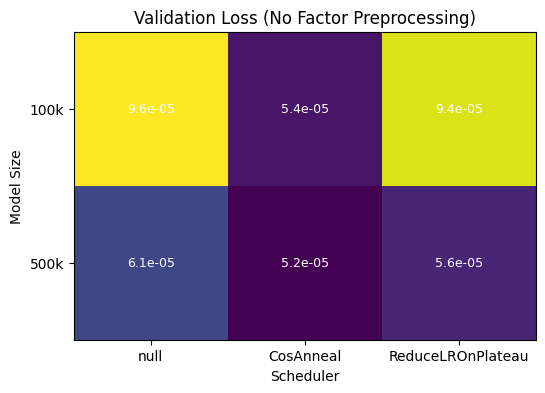

In [63]:
# Define grid axes
model_sizes = ['100k', '500k']
# perm_inv_flags = ['True', 'False']
# lrs = ['1e-3', '1e-4', '1e-5']
scheds = ['null', 'CosAnneal', 'ReduceLROnPlateau']
factor_preprocessing = ['True', 'False']

# Initialize 2D grid: [model_size, scheduler]
val_grid = np.full((len(model_sizes), len(scheds)), np.nan)

# Fill the grid
for key, val in best_val.items():
    if 'factor_ppd' in key:
        continue  # Skip models with factor preprocessing

    for i, ms in enumerate(model_sizes):
        if ms in key:
            for j, sched in enumerate(scheds):
                if f'sched_{sched}' in key:
                    val_grid[i, j] = val

# Plotting heatmap
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(val_grid, cmap='viridis', vmin=np.nanmin(val_grid), vmax=np.nanmax(val_grid))

# Set ticks
ax.set_xticks(np.arange(len(scheds)))
ax.set_xticklabels(scheds)
ax.set_yticks(np.arange(len(model_sizes)))
ax.set_yticklabels(model_sizes)

# Axis labels
ax.set_xlabel("Scheduler")
ax.set_ylabel("Model Size")
ax.set_title("Validation Loss (No Factor Preprocessing)")

# Annotate values
for i in range(len(model_sizes)):
    for j in range(len(scheds)):
        val = val_grid[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.1e}", ha="center", va="center", color="white", fontsize=9)

# Colorbar
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
# cbar.set_label("Validation Loss")
fig.savefig("val_loss_heatmap2.pdf", dpi=300)
plt.show()

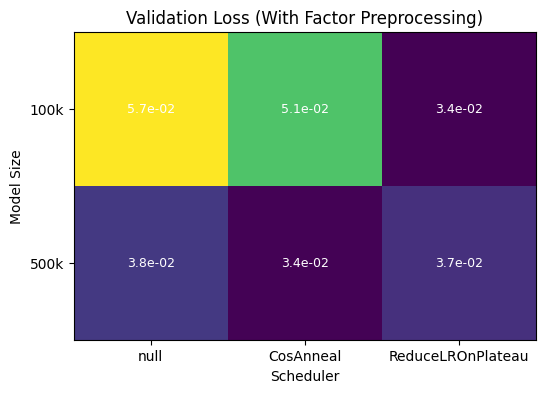

In [64]:
# Define grid axes
model_sizes = ['100k', '500k']
# perm_inv_flags = ['True', 'False']
# lrs = ['1e-3', '1e-4', '1e-5']
scheds = ['null', 'CosAnneal', 'ReduceLROnPlateau']
factor_preprocessing = ['True', 'False']

# Initialize 2D grid: [model_size, scheduler]
val_grid = np.full((len(model_sizes), len(scheds)), np.nan)

# Fill the grid
for key, val in best_val.items():
    if 'factor_ppd' not in key:
        continue  # Skip models with factor preprocessing
    for i, ms in enumerate(model_sizes):
        if ms in key:
            for j, sched in enumerate(scheds):
                if f'sched_{sched}' in key:
                    val_grid[i, j] = val

# Plotting heatmap
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(val_grid, cmap='viridis', vmin=np.nanmin(val_grid), vmax=np.nanmax(val_grid))

# Set ticks
ax.set_xticks(np.arange(len(scheds)))
ax.set_xticklabels(scheds)
ax.set_yticks(np.arange(len(model_sizes)))
ax.set_yticklabels(model_sizes)

# Axis labels
ax.set_xlabel("Scheduler")
ax.set_ylabel("Model Size")
ax.set_title("Validation Loss (With Factor Preprocessing)")

# Annotate values
for i in range(len(model_sizes)):
    for j in range(len(scheds)):
        val = val_grid[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.1e}", ha="center", va="center", color="white", fontsize=9)

# Colorbar
# Colorbar
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
# cbar.set_label("Validation Loss")
fig.savefig("val_loss_heatmap3.pdf", dpi=300)
plt.show()